# Reduced-dimension Emulator: Reaction-Diffusion example

### Overview
In this example, we aim to create an _emulator_ to generate solutions to a 2D parameterized reaction-diffusion problem governed by the following partial differential equations:

$$
\dot{u} = (1 - (u^2 + v^2)) u + \beta (u^2 + v^2) v + d (u_{xx} + u_{yy}),
$$
$$
\dot{v} = -\beta (u^2 + v^2) u + (1 - (u^2 + v^2)) v + d (v_{xx} + v_{yy}),
$$

where:
- $ u $ and $ v $ are the concentrations of two species,
- $ \beta $ and $ d $ control the reaction and diffusion terms.

This system exhibits complex spatio-temporal dynamics such as spiral waves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.reactiondiffusion import simulate_reactiondiffusion
from autoemulate.compare import AutoEmulate

/Users/pconti/Desktop/AutoEmulator/autoemulate/autoemulate/compare.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 1) Data generation
Data are computed using a numerical [_simulator_](https://github.com/dynamicslab/pysindy/blob/master/examples/10_PDEFIND_examples.ipynb) using Fourier spectral method.
The simulator takes two inputs: the reaction parameter $\beta$ and the diffusion parameter $d$.

We sample 80 sets of inputs `X` using Latin Hypercube sampling and run the simulator for those inputs to get the solutions `Y`.


In [2]:
save = False
train = False

In [3]:
n = 50
if train:
    seed = 42
    np.random.seed(seed)

    beta = (1., 2.) # lower and upper bounds for the reaction coefficient
    d = (0.05, 0.3) # lower and upper bounds for the diffusion coefficient
    lhd = LatinHypercube([beta, d])
    n_samples = 50
    n = 50
    X = lhd.sample(n_samples)
    U, V = zip(*[simulate_reactiondiffusion(x, n=n, T=10) for x in tqdm(X)])
    U = np.stack(U)
    V = np.stack(V)

    # Let's consider as output the concentration of the specie U
    Y = U.reshape(n_samples, -1)

    print(f"shapes: input X: {X.shape}, output Y: {Y.shape}\n")

In [4]:
# Save X and Y data in the "data" folder in the subfolder "reactiondiffusion" (create the subfloder if it does not exist)
X_file = "X.csv"
Y_file = "Y.csv"
if save: 
    data_folder = "autoemulate/data/reactiondiffusion"
    pd.DataFrame(X).to_csv(X_file, index=False)
    pd.DataFrame(Y).to_csv(Y_file, index=False)

# Load the data
if not train:
    X = pd.read_csv(X_file).values
    Y = pd.read_csv(Y_file).values


`X` and `Y` are matrices where each row represents one run of the simulation.  In the input matrix `X` each column is a different input parameters. 
In the output matrix `Y` each column indicates a spatial location where the solution (i.e. the concentration of $U$ at final time $T$) is computed. <br>
We consider a 2D spatial grid of $32\times 32$ points, therefore each row of `Y` corresponds to a 1024-dimensional vector!

Let’s now plot the simulated data to see how the reaction-diffusion pattern looks like.

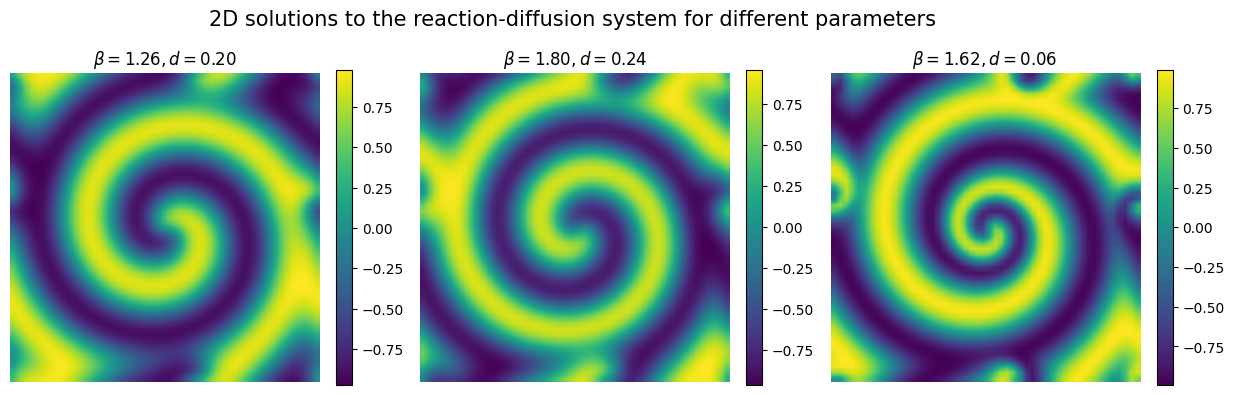

In [5]:
plt.figure(figsize=(15,4.5))
for param in range(3):
  plt.subplot(1,3,1+param)
  plt.imshow(Y[param].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title(r'$\beta = {:.2f}, d = {:.2f}$'.format(X[param][0], X[param][1]), fontsize=12)
  plt.colorbar(fraction=0.046)
plt.suptitle('2D solutions to the reaction-diffusion system for different parameters', fontsize=15)
plt.show()

## 2) Reduced-dimension Emulator
The numerical simulator is computationally expensive to run, thus we aim to replace it with a fast _emulator_.
As output we aim to emulate is the full spatial fields of the concentration of $U$ which is high-dimensional, we employ dimensionality reduction techniques to create a faster and more efficient emulator.

You can do so by selecting `reduce_dim_output=True` and indicate which dimensionality reducer `dim_reducer_output` you want to use among:
- `"PCA"`: Principal Component Analysis (deafult),
- `"AE"`: Autoencoder,
- `"VAE"`: Variational Autoencoder,

which will be trained together with the emulator.

In [12]:
em = AutoEmulate()
preprocessing_methods = [{"name": "VAE", "params": {"n_components": 32}},
                        {"name": "VAE", "params": {"n_components": 2}}]


em.setup(X, Y, models=["gp"], reduce_dim_output=True, preprocessing_methods=preprocessing_methods)
best_model = em.compare()

,Values
Simulation input shape (X),"(50, 2)"
Simulation output shape (y),"(50, 2500)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True
Dimensionality output reduction method (dim_reducer_output),PCA
Cross validator (cross_validator),KFold


Initializing:   0%|          | 0/2 [00:00<?, ?it/s]

'\n#TODO: fix VAE when passed among other options (it is not taking n_components)\nem = AutoEmulate()\npreprocessing_methods = [{"name": "PCA", "params": {"n_components": 2}},\n                         {"name": "PCA", "params": {"n_components": 8}},\n                         {"name": "VAE", "params": {"n_components": 2}}]\n\nem.setup(X, Y, models=["gp"], reduce_dim_output=True, preprocessing_methods=preprocessing_methods)\nbest_model = em.compare()\n'

In [ ]:
#TODO: now the commmand predict predicts at latent level but it does not reconstruct

In [ ]:
best_model
#TODO: print of the best model could be improved

{'preprocessing': 'VAE',
 'model': 'GaussianProcess',
 'transformer': VAEOutputPreprocessor(device='cpu', epochs=2000, hidden_dims=[64, 32],
                       latent_dim=2)}

## 3) Summarising cross-validation results
We can look at the cross-validation results to see which model provides the best emulator. 

In [ ]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,VAE,GaussianProcess,gp,1,0.179770,0.972512
1,VAE,GaussianProcess,gp,0,0.245511,0.950503
2,VAE,GaussianProcess,gp,3,0.316571,0.946310
3,VAE,GaussianProcess,gp,2,0.295752,0.945496
4,VAE,GaussianProcess,gp,4,0.420088,0.868576


We can select the best performing emulator model (in this case GaussianProcess) and see how it performs on the test-set, which AutoEmulate automatically sets aside.

We can plot the test-set performance for chosen emulator.

In [9]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,VAE,0.0709,-37.0675


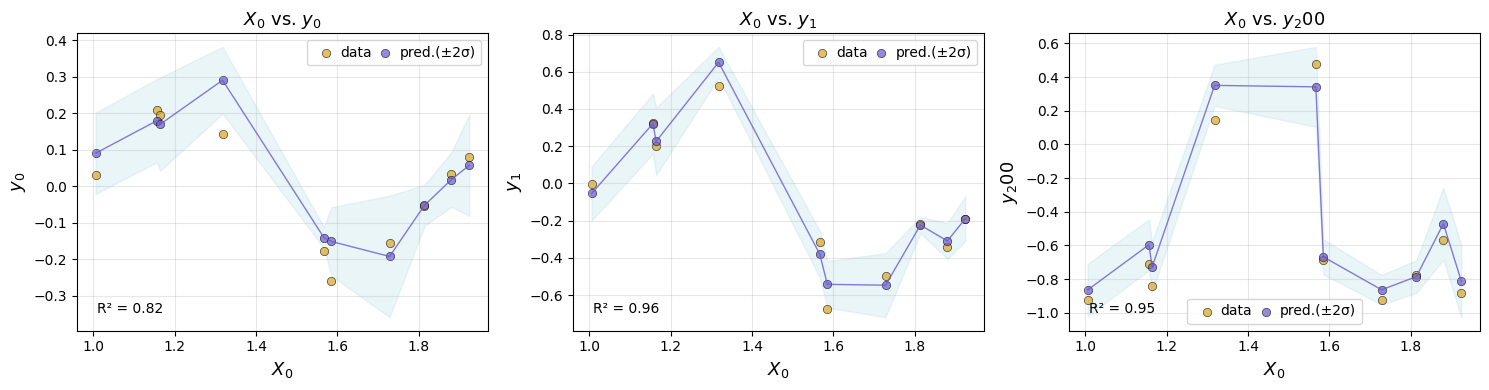

In [10]:
em.plot_eval(gp, input_index=[0], output_index=[0,1,200])

## 4) Refitting the model on the full dataset
AutoEmulate splits the dataset into a training and holdout set. All cross-validation, parameter optimisation and model selection is done on the training set. After we selected a best emulator model, we can refit it on the full traiing dataset.

In [11]:
gp_final = em.refit(gp)
#TODO: fix refit method 
#It is not doing dimenisonality reduction so far

## 5) Predict on the test set
Now we run the emulator for unseen combinations of reaction and diffusion parameter and we compare its performance with respect to the reference (simulator)

In [ ]:
y_pred = gp_final.predict(X[em.test_idxs])
y_true = Y[em.test_idxs]

In [ ]:
# Plot the results for some unseen (test) parameter instances
params_test = [0,1,2,3]

for param_test in params_test:
  plt.figure(figsize=(15,4.5))
  plt.subplot(1,3,1)
  plt.imshow(y_pred[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Prediction (emulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,3,2)
  plt.imshow(y_pred[param_test].reshape(n,n), interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('True solution (simulator)', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.subplot(1,3,3)
  plt.imshow(np.abs(y_pred[param_test] - y_true[param_test]).reshape(n,n), cmap = 'bwr', interpolation='bilinear')
  plt.axis('off')
  plt.xlabel('x', fontsize=12)
  plt.ylabel('y')
  plt.title('Absolute error', fontsize=12)
  plt.colorbar(fraction=0.046)

  plt.suptitle(r'Results for test parameters: $\beta = {:.2f}, d = {:.2f}$'.format(X[param_test][0], X[param_test][1]), fontsize=12)
  plt.show()